## **Libraries**

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import branca
from collections import defaultdict

%matplotlib inline

## **Data**

In [2]:
# Import data as dataframe
data = pd.read_csv("/kaggle/input/train-with-sizes/train_with_sizes.csv")

In [3]:
# Display data dataframe
data

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353
...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0,3072,3072
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0,2304,2880


In [4]:
# Calculate the normalisation of each coordinate
data['x_min_norm'] = data['x_min']/data['width']
data['y_min_norm'] = data['y_min']/data['height']

data['x_max_norm'] = data['x_max']/data['width']
data['y_max_norm'] = data['y_max']/data['height']

# Calculate the center of this new bounding box
data['x_mid'] = (data['x_max_norm']+data['x_min_norm'])/2
data['y_mid'] = (data['y_max_norm']+data['y_min_norm'])/2

# Calculate the width/height and area of this new bounding box
data['w'] = data['x_max_norm']-data['x_min_norm']
data['h'] = data['y_max_norm']-data['y_min_norm']
data['area'] = data['w']*data['h']

data.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_min_norm,y_min_norm,x_max_norm,y_max_norm,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,0.332212,0.588613,0.794712,0.783818,0.563462,0.686216,0.462500,0.195205,0.090283
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,0.548611,0.257986,0.699219,0.353819,0.623915,0.305903,0.150608,0.095833,0.014433
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072,0.246850,0.116211,0.372835,0.140951,0.309843,0.128581,0.125984,0.024740,0.003117
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555,0.589497,0.095890,0.957549,0.848924,0.773523,0.472407,0.368053,0.753033,0.277156
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,0.216900,0.701461,0.262850,0.740829,0.239875,0.721145,0.045950,0.039368,0.001809


In [5]:
# Create a column for the image path
data['image_path'] = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/' + data['image_id'] + '.dicom'

In [6]:
data.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_min_norm,y_min_norm,x_max_norm,y_max_norm,x_mid,y_mid,w,h,area,image_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,0.332212,0.588613,0.794712,0.783818,0.563462,0.686216,0.462500,0.195205,0.090283,/kaggle/input/vinbigdata-chest-xray-abnormalit...
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,0.548611,0.257986,0.699219,0.353819,0.623915,0.305903,0.150608,0.095833,0.014433,/kaggle/input/vinbigdata-chest-xray-abnormalit...
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072,0.246850,0.116211,0.372835,0.140951,0.309843,0.128581,0.125984,0.024740,0.003117,/kaggle/input/vinbigdata-chest-xray-abnormalit...
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555,0.589497,0.095890,0.957549,0.848924,0.773523,0.472407,0.368053,0.753033,0.277156,/kaggle/input/vinbigdata-chest-xray-abnormalit...
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,0.216900,0.701461,0.262850,0.740829,0.239875,0.721145,0.045950,0.039368,0.001809,/kaggle/input/vinbigdata-chest-xray-abnormalit...


## **Data visualisation**

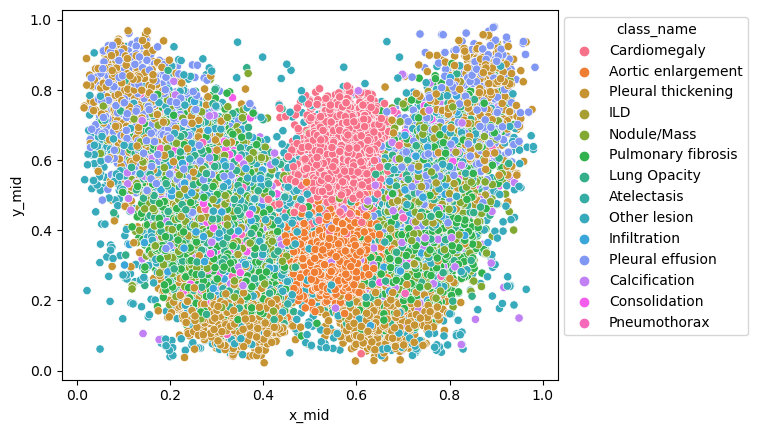

In [7]:
# Display the position of the center of each abnormality bounding box
ax = sns.scatterplot(data=data, x="x_mid", y="y_mid", hue="class_name")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

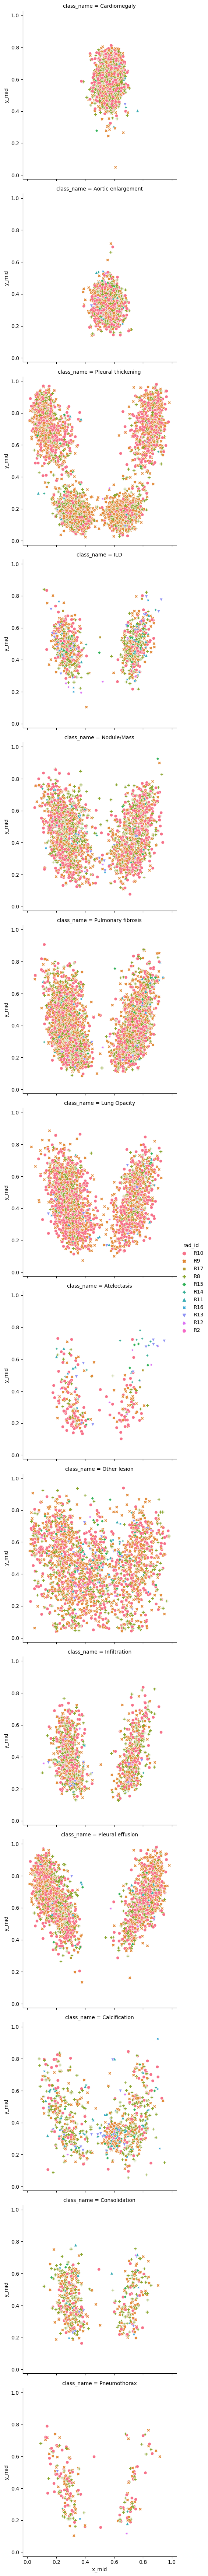

In [8]:
# Display the position of the center of each abnormality bounding box given by which radiologists
sns.relplot(
    data=data, x="x_mid", y="y_mid",
    row="class_name", hue="rad_id", style="rad_id",
    kind="scatter"
)

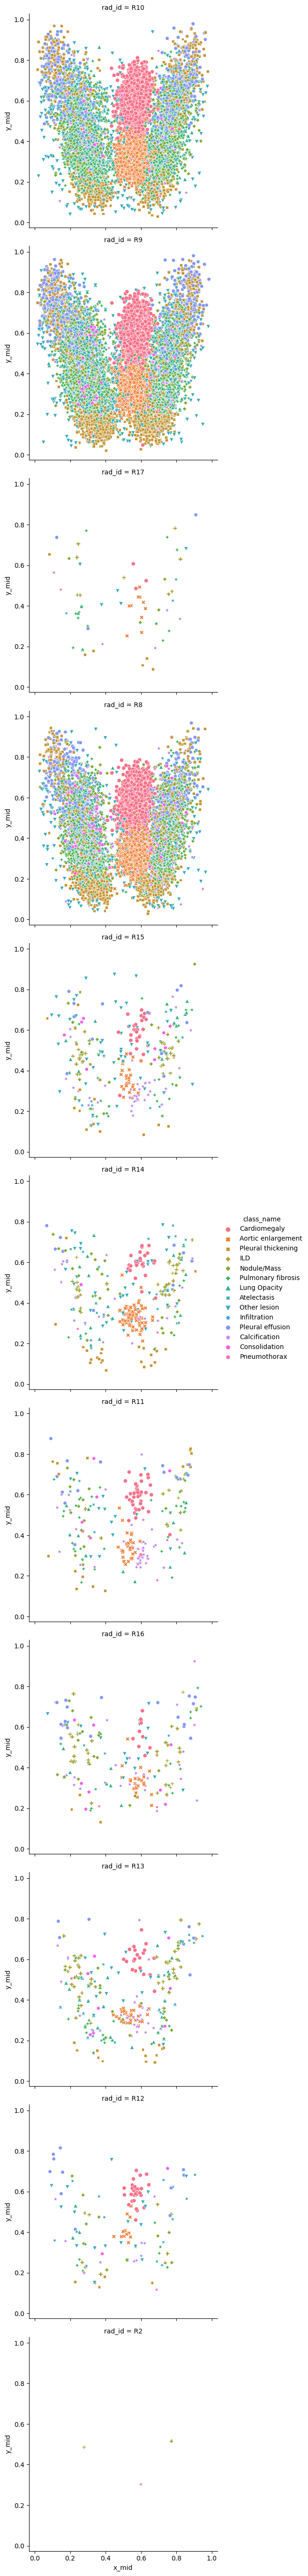

In [9]:
# Display all the position of the center of each abnormality bounding box given by which radiologists
sns.relplot(
    data=data, x="x_mid", y="y_mid",
    row="rad_id", hue="class_name", style="class_name",
    kind="scatter"
)

In [10]:
# Function that creates an array from a DICOM image
# INPUT: path of the DICOM image
# OUPUT: array of the corresponding image
def read_xray(path, voi_lut = True, fix_monochrome = True):
    
    # Reading DICOM image
    dicom = pydicom.read_file(path)
    
    # Using VOI LUT (if available by DICOM device) to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # Depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    # Standardizing the array
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [11]:
# Function that draws bounding boxes on X-ray images
# INPUT: path of the DICOM image
# OUPUT: None
def draw_rectangles(path):
    
    # Create a dataframe depending on the image path
    df = data[data['image_path']==path]
    df.reset_index(inplace=True, drop=True)
    
    # List the different classes for this specific image
    classes = list(df['class_name'].unique())
    steps = len(classes)
    
    # Create a colormap for bounding boxes from the same abnormalities
    index=[i for i in range(0,steps+1)]
    colormap = branca.colormap.LinearColormap(['purple','blue','green','yellow','orange','red'],vmin=1, vmax=steps+1).to_step(index=index)
    gradient_map=defaultdict(dict)
    for i in range(1,steps+1):
        gradient_map[classes[i-1]] = colormap.rgb_hex_str(i)
    
    # Convert the DICOM image into array 
    img = read_xray(path)
    
    # Display the image
    fig, ax = plt.subplots()
    ax.imshow(img, 'gray')
    
    # Create each bounding box
    for i in range(len(df)):
        # Plot the points on the figure
        ax.scatter([df['x_min'][i], df['x_min'][i], df['x_max'][i], df['x_max'][i]], [df['y_min'][i], df['y_max'][i], df['y_min'][i], df['y_max'][i]], color=gradient_map[df['class_name'][i]], s=5)
        
        # Create a `matplotlib` patch for the rectangle
        rect = Rectangle((df['x_min'][i],df['y_min'][i]), width=df['x_max'][i]-df['x_min'][i], height=df['y_max'][i]-df['y_min'][i], linewidth=1, edgecolor=gradient_map[df['class_name'][i]], facecolor='none', label=df['class_name'][i])

        # Add the rectangle patch to the axis
        ax.add_patch(rect)
    
    # No duplicates in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))
    
    # Show
    plt.show()

Image ID:  47ed17dcb2cbeec15182ed335a8b5a9e


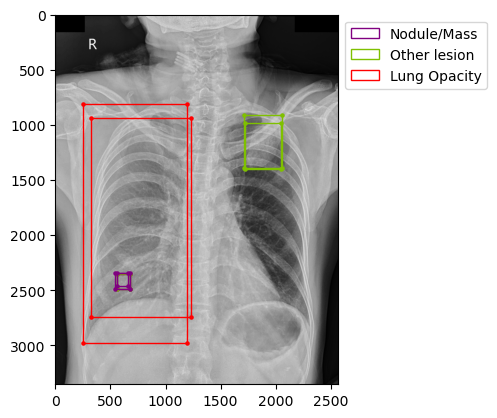

In [12]:
# Drawing bounding box for a specific DICOM image
print("Image ID: ", data['image_path'][4].split('/')[-1].split('.')[0])
draw_rectangles(data['image_path'][4])